# __Downloading the dataset__

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget 146.56.188.7/data25000.zip

--2022-12-17 23:58:33--  http://146.56.188.7/data25000.zip
Connecting to 146.56.188.7:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8532916085 (7.9G) [application/zip]
Saving to: ‘data25000.zip’

data25000.zip       100%[===================>]   7.95G  36.0MB/s    in 6m 7s   

2022-12-18 00:04:39 (22.2 MB/s) - ‘data25000.zip’ saved [8532916085/8532916085]



In [ ]:
!unzip data25000.zip

In [ ]:
! unzip /content/drive/MyDrive/Colab_Notebooks/17000.zip

# __Importing required libraries__

In [ ]:
import os
import imageio
import numpy as np
from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
import json

# __Augmentation for face__

In [ ]:
class FaceAugmentation:
    def __init__(self,
                 image_dim,
                 brightness,    
                 contrast,
                 saturation,
                 hue,
                 face_offset,
                 crop_offset):
        
        self.image_dim = image_dim
        self.face_offset = face_offset
        self.crop_offset = crop_offset
        self.transform = transforms.ColorJitter(brightness, contrast, saturation, hue)
    
    def offset_crop(self, image, landmarks, crops_coordinates):
        left = round(crops_coordinates[0]) - self.face_offset
        top = round(crops_coordinates[1]) - self.face_offset
        width = round(crops_coordinates[2] - crops_coordinates[0]) + (2 * self.face_offset)
        height = round(crops_coordinates[3] - crops_coordinates[1]) + (2 * self.face_offset)

        image = TF.crop(image, top, left, height, width)
        landmarks = landmarks - np.array([[left, top]])

        new_dim = self.image_dim + self.crop_offset

        image = TF.resize(image, (new_dim, new_dim))

        landmarks[:, 0] *= new_dim / width
        landmarks[:, 1] *= new_dim / height

        return image, landmarks
    
    def random_face_crop(self, image, landmarks):
        image = np.array(image)

        h, w = image.shape[:2]

        top = np.random.randint(0, h - self.image_dim)
        left = np.random.randint(0, w - self.image_dim)

        image = image[top: top + self.image_dim, left: left + self.image_dim]

        landmarks = landmarks - np.array([[left, top]])

        return TF.to_pil_image(image), landmarks
    
    def __call__(self, image, landmarks, crops_coordinates):
        image, landmarks = self.offset_crop(image, landmarks, crops_coordinates)

        image, landmarks = self.random_face_crop(image, landmarks)

        return self.transform(image), landmarks

# __Augmentation for landmarks__

In [ ]:
class LandmarksAugmentation:
    def __init__(self, rotation_limit):
        self.rotation_limit = rotation_limit

    def random_rotation(self, image, landmarks):
        angle = np.random.uniform(-self.rotation_limit, self.rotation_limit)
        landmarks_transformation = np.array([
            [+np.cos(np.radians(angle)), -np.sin(np.radians(angle))], 
            [+np.sin(np.radians(angle)), +np.cos(np.radians(angle))]
        ])
        image = TF.rotate(image, angle)
        landmarks = landmarks - 0.5
        transformed_landmarks = np.matmul(landmarks, landmarks_transformation)
        transformed_landmarks = transformed_landmarks + 0.5

        return image, transformed_landmarks
    
    def __call__(self, image, landmarks):
        image, landmarks = self.random_rotation(image, landmarks)
        return image, landmarks

# __Data Preprocessing__

In [ ]:
class Preprocessor:
    def __init__(self,
                 image_dim,
                 brightness,
                 contrast,
                 saturation,
                 hue,
                 angle,
                 face_offset,
                 crop_offset):
        
        self.image_dim = image_dim

        self.landmarks_augmentation = LandmarksAugmentation(angle)
        self.face_augmentation = FaceAugmentation(image_dim, brightness, contrast, saturation, hue, face_offset, crop_offset)
    
    def __call__(self, image, landmarks, crops_coordinates):
        image = TF.to_pil_image(image)
        image = TF.resize(image, (512, 512))

        image, landmarks = self.face_augmentation(image, landmarks, crops_coordinates)

        landmarks = landmarks / np.array([*image.size])

        image, landmarks = self.landmarks_augmentation(image, landmarks)

        image = TF.to_grayscale(image)

        image = TF.to_tensor(image)

        image = (image - image.min())/(image.max() - image.min())
        image = (2 * image) - 1

        return image, torch.FloatTensor(landmarks.reshape(-1) - 0.5)

# __Creating the dataset class__

# **With Data Mixing**

In [ ]:
f = open('/content/drive/MyDrive/CMPT732/project/ffhq-dataset-v2.json')
data = json.load(f)

In [ ]:
from matplotlib.lines import Bbox

class LandmarksDataset(Dataset):
    def __init__(self, preprocessor, train):
        self.root_dir = '/content/dataset_10000/trainset'
        self.real_root = '/content/17000'
        self.real_img_path = sorted(os.listdir('/content/17000'))

        self.image_paths = []
        self.landmarks = []
        self.crops = []
        self.preprocessor = preprocessor
        self.train = train
        
        files = sorted(os.listdir(self.root_dir))
        img_list = [x for x in files if '.png' in x and 'seg' not in x]
        ldmk_list = [x for x in files if '.txt' in x]
        print('CG_imgs:', len(img_list))
        print('CG_ldmk:', len(ldmk_list))

        for img in img_list:
          self.image_paths.append(os.path.join(self.root_dir, img))
        
        for ldmk in ldmk_list:
          landmark = []
          with open(os.path.join(self.root_dir, ldmk)) as l_m:
            labels = l_m.readlines()[:71]
            for _one_p in labels:
                xy = _one_p.rstrip().split(' ')
                landmark.append([float(xy[0]), float(xy[1])])

          rs_landmrk = np.array(landmark).reshape((-1, 2))
          rs_landmrk = rs_landmrk[:68, :]
          bbox = [float(np.min(rs_landmrk[:, 0])), float(np.min(rs_landmrk[:, 1])), float(np.max(rs_landmrk[:, 0])), float(np.max(rs_landmrk[:, 1]))]

          self.landmarks.append(rs_landmrk)
          self.crops.append(bbox)

        #Add 1000 Real Face images 

        for img_path in self.real_img_path:
          self.image_paths.append(os.path.join(self.real_root, img_path))
          ind = img_path.split(".")[0]
          landmark = np.array(data[ind]['image']['face_landmarks'])
          landmark[:, 0] *= 512/1024
          landmark[:, 1] *= 512/1024
          real_bbox = [float(np.min(landmark[:, 0])), float(np.min(landmark[:, 1])), float(np.max(landmark[:, 0])), float(np.max(landmark[:, 1]))]
          self.landmarks.append(landmark)
          self.crops.append(real_bbox)
          
        print('real_imgs:', len(self.image_paths))
        self.landmarks = np.array(self.landmarks)
        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = io.imread(self.image_paths[index], as_gray = False)
        landmarks = self.landmarks[index]
        
        image, landmarks = self.preprocessor(image, landmarks, self.crops[index])

        return image, landmarks

# **Without data mixing**

In [ ]:
from matplotlib.lines import Bbox

class LandmarksDataset(Dataset):
    def __init__(self, preprocessor, train):
        self.root_dir = '/content/dataset_10000/trainset'
        self.image_paths = []
        self.landmarks = []
        self.crops = []
        self.preprocessor = preprocessor
        self.train = train
        
        files = sorted(os.listdir(self.root_dir))
        img_list = [x for x in files if '.png' in x and 'seg' not in x]
        ldmk_list = [x for x in files if '.txt' in x]
        print('CG_imgs:', len(img_list))
        print('CG_ldmk:', len(ldmk_list))

        for img in img_list:
          self.image_paths.append(os.path.join(self.root_dir, img))
        
        for ldmk in ldmk_list:
          landmark = []
          with open(os.path.join(self.root_dir, ldmk)) as l_m:
            labels = l_m.readlines()[:71]
            for _one_p in labels:
                xy = _one_p.rstrip().split(' ')
                landmark.append([float(xy[0]), float(xy[1])])

          rs_landmrk = np.array(landmark).reshape((-1, 2))
          rs_landmrk = rs_landmrk[:68, :]
          bbox = [float(np.min(rs_landmrk[:, 0])), float(np.min(rs_landmrk[:, 1])), float(np.max(rs_landmrk[:, 0])), float(np.max(rs_landmrk[:, 1]))]

          self.landmarks.append(rs_landmrk)
          self.crops.append(bbox)
          
        self.landmarks = np.array(self.landmarks)
        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = io.imread(self.image_paths[index], as_gray = False)
        landmarks = self.landmarks[index]
        
        image, landmarks = self.preprocessor(image, landmarks, self.crops[index])

        return image, landmarks

# __Some helper functions for visualizing the data__

In [ ]:
def visualize_image(image, landmarks):
    plt.figure(figsize = (5, 5))
    image = (image - image.min())/(image.max() - image.min())

    landmarks = landmarks.view(-1, 2)
    landmarks = (landmarks + 0.5) * preprocessor.image_dim

    plt.imshow(image[0], cmap = 'gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 25, c = 'dodgerblue')
    plt.axis('off')
    plt.show()
    
def visualize_batch(images_list, landmarks_list, size = 14, shape = (6, 6), title = None, save = None):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        image = (image - image.min())/(image.max() - image.min())

        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5) * preprocessor.image_dim
        landmarks = landmarks.numpy().tolist()
        landmarks = np.array([(x, y) for (x, y) in landmarks if 0 <= x <= preprocessor.image_dim and 0 <= y <= preprocessor.image_dim])

        ax.imshow(image[0], cmap = 'gray')
        ax.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, c = 'dodgerblue')
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

# __Initializing preprocessor, train and test images__

In [ ]:
preprocessor = Preprocessor(image_dim = 128,brightness = 0.24,saturation = 0.3,contrast = 0.15,hue = 0.14,angle = 14,face_offset = 32,crop_offset = 16)

train_images = LandmarksDataset(preprocessor, train = True)

CG_imgs: 25568
CG_ldmk: 25568


# __Visualizing a sample image, with random augmentations__

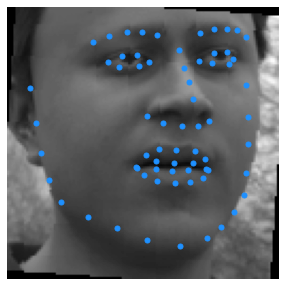

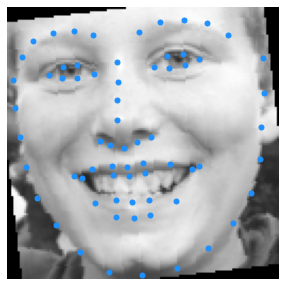

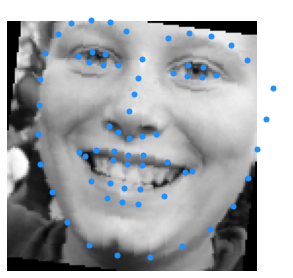

In [ ]:
#CG-Face
image1, landmarks1 = train_images[25567]
visualize_image(image1, landmarks1)
#Real-Face
image2, landmarks2 = train_images[25568]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_images[25568]
visualize_image(image3, landmarks3)

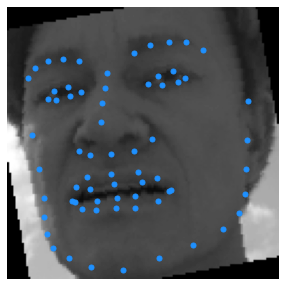

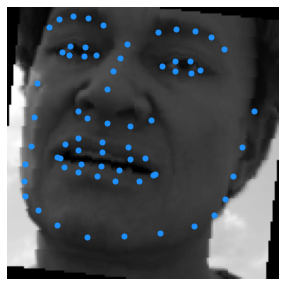

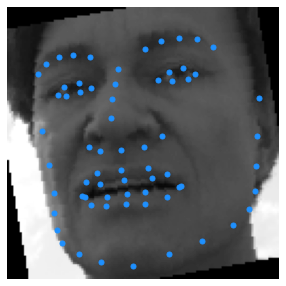

In [ ]:
#CG-Face (without data mixing)
image1, landmarks1 = train_images[25]
visualize_image(image1, landmarks1)

image2, landmarks2 = train_images[25]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_images[25]
visualize_image(image3, landmarks3)

In [ ]:
whole_set = int(0.22 * len(train_images))
other_set = len(train_images) - whole_set
train_images, others = random_split(train_images, [whole_set, other_set])

len_val_set = int(0.1 * whole_set)
len_test_set = int(0.1 * whole_set)

len_val_set = int(0.1 * len(train_images))

len_train_set = len(train_images) - len_val_set
train_images, val_images = random_split(train_images, [len_train_set, len_val_set])

batch_size = 32
train_data = torch.utils.data.DataLoader(train_images, batch_size = batch_size, shuffle = True)
val_data = torch.utils.data.DataLoader(val_images, batch_size = 2 * batch_size, shuffle = False)

print(f'{len_train_set} images for training')
print(f'{len_val_set} images for validating')

5062 images for training
562 images for validating


In [ ]:
whole_set = int(0.22 * len(train_images))
other_set = len(train_images) - whole_set
train_images, others = random_split(train_images, [whole_set, other_set])

len_val_set = int(0.1 * whole_set)
len_test_set = int(0.1 * whole_set)

len_val_set = int(0.1 * len(train_images))

len_train_set = len(train_images) - len_val_set
train_images, val_images = random_split(train_images, [len_train_set, len_val_set])

batch_size = 32
train_data = torch.utils.data.DataLoader(train_images, batch_size = batch_size, shuffle = True)
val_data = torch.utils.data.DataLoader(val_images, batch_size = 2 * batch_size, shuffle = False)

print(f'{len_train_set} images for training')
print(f'{len_val_set} images for validating')

5062 images for training
562 images for validating


# __Visualizing a sample batch__

In [ ]:
for x, y in train_data:
    break
print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in val_data:
    break
print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

torch.Size([32, 1, 128, 128]) torch.Size([32, 136]) tensor(1.) tensor(-1.) tensor(0.5326) tensor(-0.5246)
torch.Size([64, 1, 128, 128]) torch.Size([64, 136]) tensor(1.) tensor(-1.) tensor(0.5151) tensor(-0.5192)


Training Batch Samples


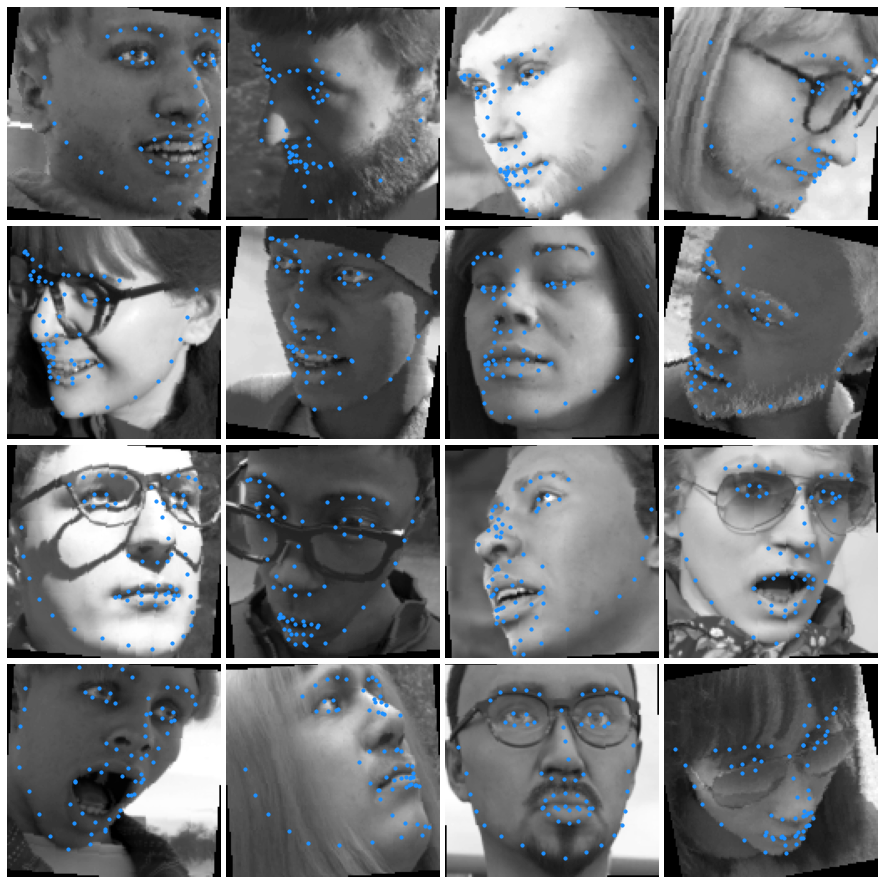

In [ ]:
visualize_batch(x[:16], y[:16], shape = (4, 4), size = 16, title = 'Training Batch Samples')

# __Creating Xception Net model architecture__

In [ ]:
class DepthewiseSeperableConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super(DepthewiseSeperableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size, groups = input_channels, bias = False, **kwargs)
        self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias = False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x

In [ ]:
class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

        self.conv4_residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.conv4_direct = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride = 2),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = self.conv3_residual(x)
        direct = self.conv3_direct(x)
        x = residual + direct
        
        residual = self.conv4_residual(x)
        direct = self.conv4_direct(x)
        x = residual + direct

        return x

In [ ]:
class MiddleBasicBlock(nn.Module):
    def __init__(self):
        super(MiddleBasicBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlock(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()

        self.block = nn.Sequential(*[MiddleBasicBlock() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)

        return x

In [ ]:
class ExitBlock(nn.Module):
    def __init__(self):
        super(ExitBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthewiseSeperableConv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x

# __Initializing the Xception Net model__

In [ ]:
class XceptionNet(nn.Module):
    def __init__(self, num_middle_blocks = 6):
        super(XceptionNet, self).__init__()

        self.entry_block = EntryBlock()
        self.middel_block = MiddleBlock(num_middle_blocks)
        self.exit_block = ExitBlock()

        self.fc = nn.Linear(1024, 136)

    def forward(self, x):
        x = self.entry_block(x)
        x = self.middel_block(x)
        x = self.exit_block(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x

In [ ]:
model = XceptionNet()
model.cuda()

XceptionNet(
  (entry_block): EntryBlock(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3_residual): Sequential(
      (0): DepthewiseSeperableConv2d(
        (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): DepthewiseSeperableConv2d(
        (dep

In [ ]:
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             288
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         LeakyReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,432
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         LeakyReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]             576
            Conv2d-8         [-1, 64, 128, 128]           4,096
DepthewiseSeperableConv2d-9         [-1, 64, 128, 128]               0
      BatchNorm2d-10         [-1, 64, 128, 128]             128
        LeakyReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]             576
           Conv2d-13        [-1, 128, 128, 128]           8,192
DepthewiseSeperableConv2d-14    

# __ResNet-50__

In [ ]:
model = torchvision.models.resnet50(weights=False, num_classes=136)

first_layer = model.conv1
weight = first_layer.weight.clone()
first_layer = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3,3), bias=False)
with torch.no_grad():
  first_layer.weight[:, :] = weight[:, :1]
model.conv1 = first_layer

model.cuda()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

# __MobileNet-v2__

In [ ]:
model = torchvision.models.mobilenet_v2(weights=False, num_classes=136)
model.cuda()

In [ ]:
first_layer = model.features[0][0]
weight = first_layer.weight.clone()
first_layer = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
with torch.no_grad():
  first_layer.weight[:, :] = weight[:, :1]
model.features[0][0] = first_layer
model.cuda()
print(model)

# __Initializing the objective loss and optimizer__

In [ ]:
objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

# __Defining validation function__

Validating:   0%|                                                                                             …

Validation sample predictions


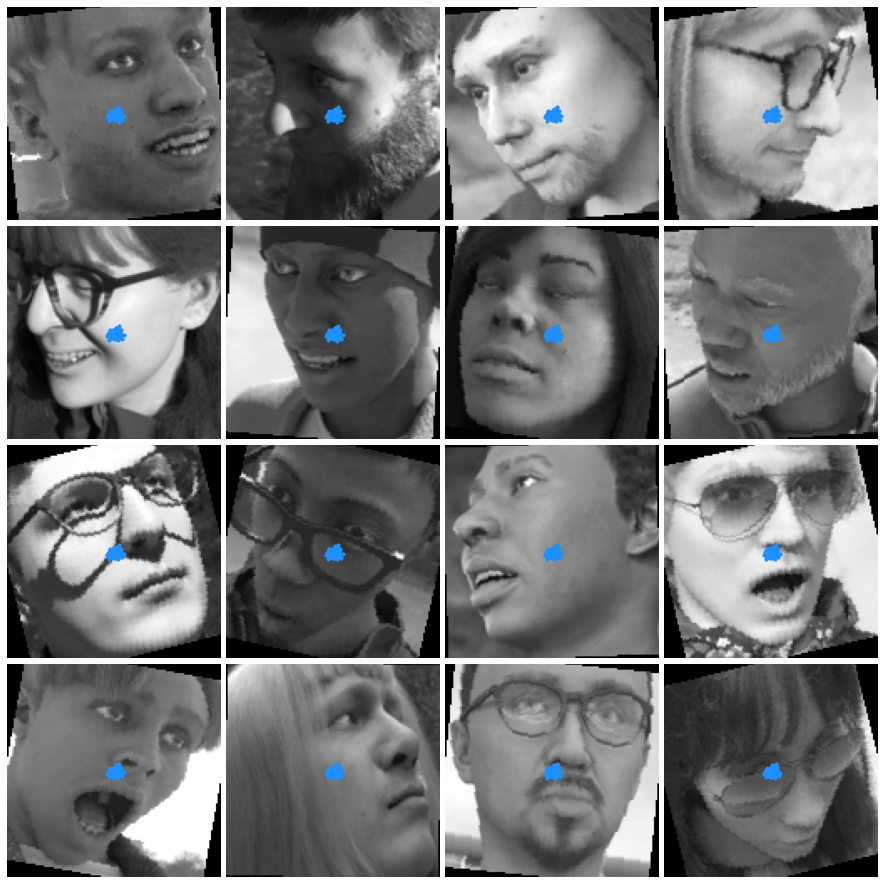

0.00660503614279959

In [ ]:
@torch.no_grad()
def validate(save = None):
    cum_loss = 0.0

    model.eval()

    for features, labels in tqdm(val_data, desc = 'Validating', ncols = 600):
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features)
       

        loss = objective(outputs, labels)

        cum_loss += loss.item()

        break
        
    visualize_batch(features[:16].cpu(), outputs[:16].cpu(), shape = (4, 4), size = 16, title = 'Validation sample predictions', save = save)

    return cum_loss/len(val_data)

validate()

# Creating directory for storing the model's progress

In [ ]:
if os.path.isdir('progress'):
    !rm -rf progress
os.mkdir('progress')

# __And finally training the model__

# **With data mixing training result**

In [ ]:
epochs = 30
batches = len(train_data)
best_loss = np.inf
optimizer.zero_grad()

train_loss = [] # initialize a list to save training losses
validation_loss = [] # initialize a list to save testing losses

for epoch in range(epochs):
    cum_loss = 0.0

    model.train()
    for batch_index, (features, labels) in enumerate(tqdm(train_data, desc = f'Epoch({epoch + 1}/{epochs})', ncols = 800)):
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features)
        
        loss = objective(outputs, labels)

        loss.backward()

        optimizer.step()
        
        optimizer.zero_grad()

        cum_loss += loss.item()

    val_loss = validate(os.path.join('progress', f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        torch.save(model.state_dict(), 'model.pt')

    train_loss.append(cum_loss/batches)
    validation_loss.append(val_loss)
    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')

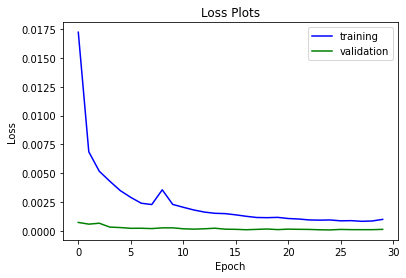

In [ ]:
fig, ax= plt.subplots()
epoch_losses = list(range(epochs))
ax.plot(epoch_losses, train_loss, label='training', color='b')
ax.plot(epoch_losses, validation_loss, label='validation', color='g')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Loss Plots')

ax.legend()
fig.show()

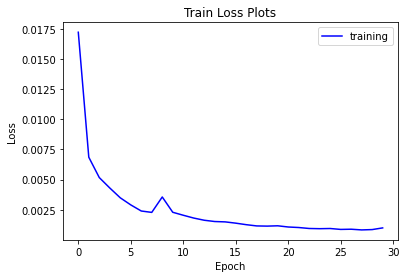

In [ ]:
fig, ax= plt.subplots()
epoch_losses = list(range(epochs))
ax.plot(epoch_losses, train_loss, label='training', color='b')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Train Loss Plots')

ax.legend()
fig.show()

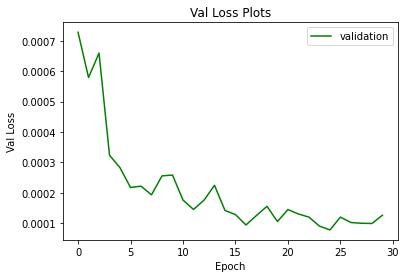

In [ ]:
fig, ax= plt.subplots()
epoch_losses = list(range(epochs))
ax.plot(epoch_losses, validation_loss, label='validation', color='g')
ax.set(xlabel='Epoch', ylabel='Val Loss',
       title='Val Loss Plots')

ax.legend()
fig.show()

# **Without data mixing training result**

In [ ]:
epochs = 30
batches = len(train_data)
best_loss = np.inf
optimizer.zero_grad()

train_loss = [] # initialize a list to save training losses
validation_loss = [] # initialize a list to save testing losses

for epoch in range(epochs):
    cum_loss = 0.0

    model.train()
    for batch_index, (features, labels) in enumerate(tqdm(train_data, desc = f'Epoch({epoch + 1}/{epochs})', ncols = 800)):
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features)
        
        loss = objective(outputs, labels)

        loss.backward()

        optimizer.step()
        
        optimizer.zero_grad()

        cum_loss += loss.item()

    val_loss = validate(os.path.join('progress', f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        torch.save(model.state_dict(), 'model.pt')

    train_loss.append(cum_loss/batches)
    validation_loss.append(val_loss)
    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')

# __Inference__

In [ ]:
model.load_state_dict(torch.load('model.pt', map_location = 'cpu'))

<All keys matched successfully>

In [ ]:
import dlib
from imutils import face_utils, resize

In [ ]:
! unzip /content/drive/MyDrive/CMPT732/project/21000.zip

In [ ]:
def preprocess_image(image, landmarks, width, height):
    image = TF.to_pil_image(image)
    image = TF.resize(image, (128, 128))

    landmarks[:, 0] *= 128 / width
    landmarks[:, 1] *= 128 / height
    landmarks = landmarks / np.array([*image.size])

    image = TF.to_tensor(image)
    image = (image - image.min())/(image.max() - image.min())
    image = (2 * image) - 1

    return image.unsqueeze(0), torch.FloatTensor(landmarks.reshape(-1) - 0.5).cuda()
def draw_landmarks_on_faces(image, faces_landmarks):
    image = image.copy()
    for landmarks, (left, top, height, width) in faces_landmarks:
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5)
        landmarks = landmarks.numpy()
        
        
        for i, (x, y) in enumerate(landmarks, 1):
            
          try:

            cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 2, [40, 117, 255], -1)
          except:

            pass
    
    return image

In [ ]:
face_detector = dlib.get_frontal_face_detector()

@torch.no_grad()
def inference(img_path):
    ind = img_path.split(".")[0]
    img = cv2.imread(os.path.join('/content/21000', img_path))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_detector(gray, 1)
    landmarks = np.array(data[ind]['image']['face_landmarks'])
    landmarks[:, 0] *= 128/1024
    landmarks[:, 1] *= 128/1024
    loss = 0.0
    outputs = []

    for (i, face) in enumerate(faces):
        (x, y, w, h) = face_utils.rect_to_bb(face)

        crop_img = gray[y: y + h, x: x + w]
        landmarks = landmarks - np.array([[x, y]])
    

        preprocessed_image, landmarks = preprocess_image(crop_img, landmarks, w, h)
        landmarks_predictions = model(preprocessed_image.cuda())
        landmarks_predictions_cut = landmarks_predictions[:, :136]
        landmarks_predictions_cut = landmarks_predictions_cut[0]
        
        loss = objective(landmarks_predictions_cut, landmarks)
        loss = loss.item()
        outputs.append((landmarks_predictions_cut.cpu(), (x, y, h, w)))

    return draw_landmarks_on_faces(img, outputs), loss

In [ ]:
img_paths = sorted(os.listdir('/content/21000'))

# **Result with data mixing**

In [ ]:
outputs = []
cum_loss = 0.0
test_loss = 0.0
for img_path in img_paths:    
        output, loss = inference(img_path)
        # loss.backward()
        cum_loss += loss
        outputs.append(output)

test_loss = cum_loss/1000
print(test_loss)

0.0018983719485113398


# **Result without data mixing**

In [ ]:
outputs = []
cum_loss = 0.0
test_loss = 0.0
for img_path in img_paths:    
        output, loss = inference(img_path)
        # loss.backward()
        cum_loss += loss
        outputs.append(output)

test_loss = cum_loss/1000
print(test_loss)

0.002772643618460279


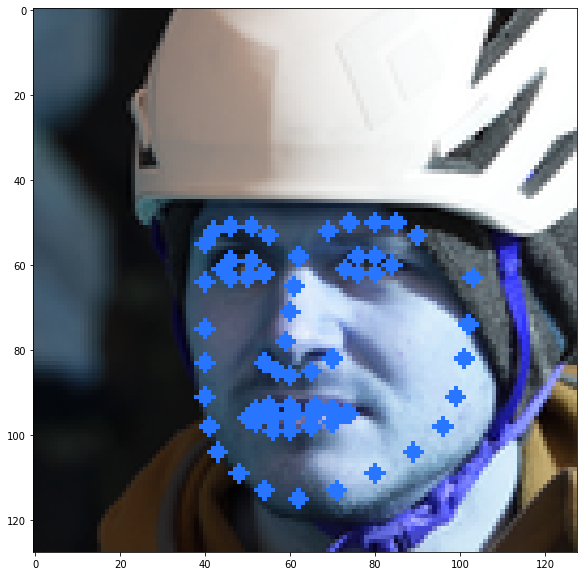

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(outputs[10]) 

# Inference-video

In [ ]:
!pip install youtube-dl
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 32.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import dlib
import youtube_dl
from imutils import face_utils, resize
!pip install moviepy==1.0.3

from moviepy.editor import VideoFileClip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 388 kB 29.5 MB/s 
     |████████████████████████████████| 26.9 MB 34.0 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110742 sha256=c9ddaeca6b02523e9ed3f13806da6a2bbb46ffa1b0e4207fb68f7f9be1531a63
  Stored in directory: /root/.cache/pip/wheels/e4/a4/db/0368d3a04033da662e13926594b3a8cf1aa4ffeefe570cfac1
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5


In [ ]:
def preprocess_image(image):
    image = TF.to_pil_image(image)
    image = TF.resize(image, (128, 128))
    image = TF.to_tensor(image)
    image = (image - image.min())/(image.max() - image.min())
    image = (2 * image) - 1
    return image.unsqueeze(0)

def draw_landmarks_on_faces(image, faces_landmarks):
    image = image.copy()
    for landmarks, (left, top, height, width) in faces_landmarks:
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5)
        landmarks = landmarks.numpy()
        
        for i, (x, y) in enumerate(landmarks, 1):
            try:
                cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 2, [40, 117, 255], -1)
            except:
                pass
    
    return image

In [ ]:
face_detector = dlib.get_frontal_face_detector()

@torch.no_grad()
def inference(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_detector(gray, 1)

    outputs = []

    for (i, face) in enumerate(faces):
        (x, y, w, h) = face_utils.rect_to_bb(face)

        crop_img = gray[y: y + h, x: x + w]
        preprocessed_image = preprocess_image(crop_img)
        landmarks_predictions = model(preprocessed_image.cuda())
        outputs.append((landmarks_predictions.cpu(), (x, y, h, w)))

    return draw_landmarks_on_faces(frame, outputs)

In [ ]:
def output_video(video, name, seconds = None):
    total = int(video.fps * seconds) if seconds else int(video.fps * video.duration)
    print('Will read', total, 'images...')
    
    outputs = []

    writer = cv2.VideoWriter(name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), video.fps, tuple(video.size))

    for i, frame in enumerate(tqdm(video.iter_frames(), total = total), 1):    
        if seconds:
            if (i + 1) == total:
                break
                
        output = inference(frame)
        outputs.append(output)

        writer.write(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

    writer.release()

    return outputs

In [ ]:
ydl_opts = {}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=SVsrVE_G6co'])

[youtube] SVsrVE_G6co: Downloading webpage
[download] Destination: demo_for_project-SVsrVE_G6co.f137.mp4
[download] 100% of 7.01MiB in 01:45
[download] Destination: demo_for_project-SVsrVE_G6co.f140.m4a
[download] 100% of 912.62KiB in 00:13
[ffmpeg] Merging formats into "demo_for_project-SVsrVE_G6co.mp4"
Deleting original file demo_for_project-SVsrVE_G6co.f137.mp4 (pass -k to keep)
Deleting original file demo_for_project-SVsrVE_G6co.f140.m4a (pass -k to keep)


In [ ]:
video = VideoFileClip("/content/HB_demo.mp4")
print('FPS:', video.fps)
print('Duration:', video.duration, 'seconds')

FPS: 30.0
Duration: 5.83 seconds


In [ ]:
for frame in video.iter_frames():
    break

print(frame.shape)
plt.figure(figsize = (11, 11))
plt.imshow(frame)

In [ ]:
outputs = output_video(video, 'LYF1_mix_output')

Will read 176 images...


  0%|          | 0/176 [00:00<?, ?it/s]

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+



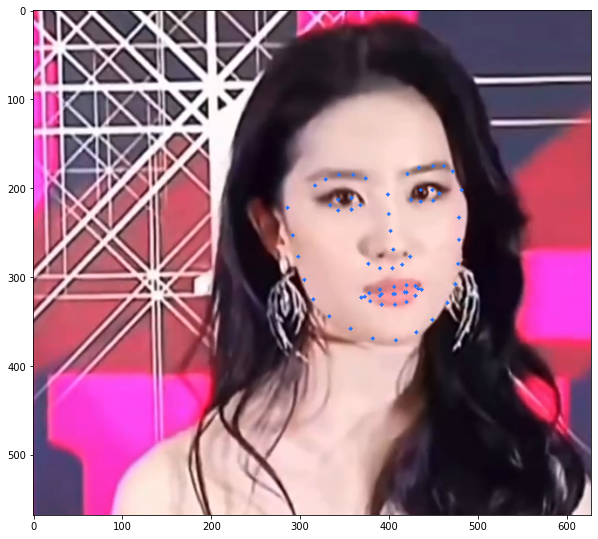

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(outputs[30])